In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from collections import namedtuple
import json

In [2]:
kinds = {0: 'Ratio-sensing', 1: 'Constitutive activation', 2: 'Recipients-density-sensing', 3: 'Population-size-sensing'}
p = {
    'lconj': 60*2e-4, #l_conj 0
    'theta': 1/2, #theta 1 1/2
    'eta': 20, #eta 2 8
    'l_d': 60*2.58e-4, #l_D, minutes-1 3
    'l_r': 60*5.35e-4, #l_R, minutes-1 4
    'k': 2, #K 5
    'mu': 60*2*1e-4, #mu 6
    'conjcost': 0.2,
    'conjeff': 100000,
    'cbreak': 60*2e-4*1e-3*0,
    'a': 1.0,
    'r50': 5.0,
    'p50': 7.0
}

def parameters_series(x):
    l = ['lconj', 'theta', 'eta', 'l_d', 'l_r', 'k', 'mu', 'conjcost', 'a', 'r50', 'p50']
    return pd.Series({k:x[k] for k in l})

def conjactivation(r,d,theta,eta,a,r50,p50,kind=0):
    if kind == 0:
        return r**eta/((theta*d)**eta + r**eta)
    elif kind == 1:
        return a*np.ones(r.shape)
    elif kind == 2:
        return r**eta/(r50**eta + r**eta)
    elif kind == 3:
        return (r+d)**eta/(p50**eta + (r+d)**eta)
    else:
        raise ValueError("Unknown kind.")
        

def dydt(_,y,p,kind=0):
    d,r = np.maximum(y,1e-30)
    l_conj, theta, eta, l_D, l_R, K, mu, conjcost, a, r50, p50  = p
    conjactiv = conjactivation(r,d,theta,eta,a,r50,p50,kind)
    conjugation =  conjactiv * l_conj * r * d
    logterm = 1 - (r+d)/K
    converted = conjugation*np.array([1,-1])
    growth = np.array([
        d*((1-conjcost*conjactiv)*l_D*logterm - mu),
        r*((l_R*logterm) - mu)]) 
    return converted + growth

Result = namedtuple('Result',['ys'])
def integrate(y0,kind,samples,parameters,rtol,atol):
    res = solve_ivp(dydt,
                    (0,samples[-1]),
                    y0,
                    method='BDF',
                    t_eval=samples,
                    args=(parameters,kind),
                    rtol=rtol,
                    atol=atol)
    df = pd.DataFrame({'t':res.t,'d': res.y[0], 'r': res.y[1]})
    df['p'] = df['r'] + df['d']
    df['f'] = df['r']/df['p']
    return Result(ys=df.to_records())
    

f0 = 0.5
p0 = 1e-3
y0 = p0*np.array([f0,0.,1-f0])
T = 30*24*60
def exp_inputs(kind):
    return [(np.array([kind]),T)]
samples_t = np.linspace(0,T,1000)

statevariables = ['d','r']
observables = ['f', 'p']

<IPython.core.display.Javascript object>


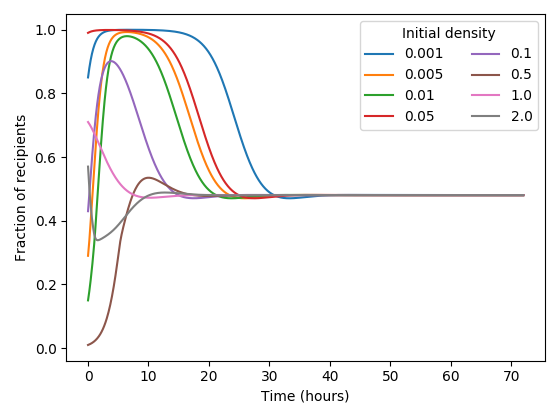

In [3]:
pops = np.array([0.001,0.005,0.01,0.05,0.1,0.5,1,2])
fracs = np.linspace(0.01,0.99,8)
np.random.seed(0)
np.random.shuffle(fracs)

scale = 7e-1

plt.figure(figsize=(scale*8,scale*6))

ress = []

for i in range(len(pops)):
    pop = pops[i]
    frac = fracs[i]
    
    res = integrate(
        y0=pop*np.array([1-frac,frac]),
        samples = np.linspace(0,3*24*60,1000),
        kind=0,
        parameters=parameters_series(p).to_numpy(),
        atol=[1e-9, 1e-30],
        rtol=1e-6
    )

    ts = res.ys['t']/60
    ress.append([pop, frac, *res.ys['f']])
    plt.plot(ts,res.ys['f'],label=f'{pop}')

plt.xlabel("Time (hours)")
plt.ylabel("Fraction of recipients")
plt.legend(title='Initial density', ncol=2)
plt.tight_layout()
df = pd.DataFrame(ress).T
df.index = ['pop0', 'r-frac0', *ts]
df.to_csv('fraction_time_traces.csv')

In [4]:
N = 10
M = 100
Ks = np.logspace(np.log10(1),np.log10(1e4),base=10,num=M)
T = 100*24*60
print(T)


def f_ss_randic(K, kind):
        p_aux = p.copy()
        p_aux['k'] = K
        pop = 10**(np.random.rand()*(-4))
        frac = np.random.rand()
        res = integrate(
            y0 = pop*np.array([1-frac, frac],dtype=np.float),
            kind = kind,
            samples = np.linspace(0,T,1000),
            parameters = parameters_series(p_aux).to_numpy(),
            atol=[1e-9,0.5e-30],
            rtol=1e-6
        )
        d,r = res.ys['d'][-1], res.ys['r'][-1]
        return (d,r,K,kind)


np.random.seed(0)
arrays = [f_ss_randic(K,kind) for K in np.repeat(Ks,N) for kind in [0,1,2,3]]
dfss = pd.DataFrame(arrays,columns = ['d', 'r', 'K', 'Strategy'])
dfss['p'] = dfss.r + dfss.d
dfss['f'] = dfss.r/dfss.p
dfss['fdon'] = dfss.d/dfss.p
dfss['Strategy'] = dfss['Strategy'].replace(to_replace=kinds)

144000


In [5]:
dfss.to_csv('dfss.csv',index=False)

<IPython.core.display.Javascript object>


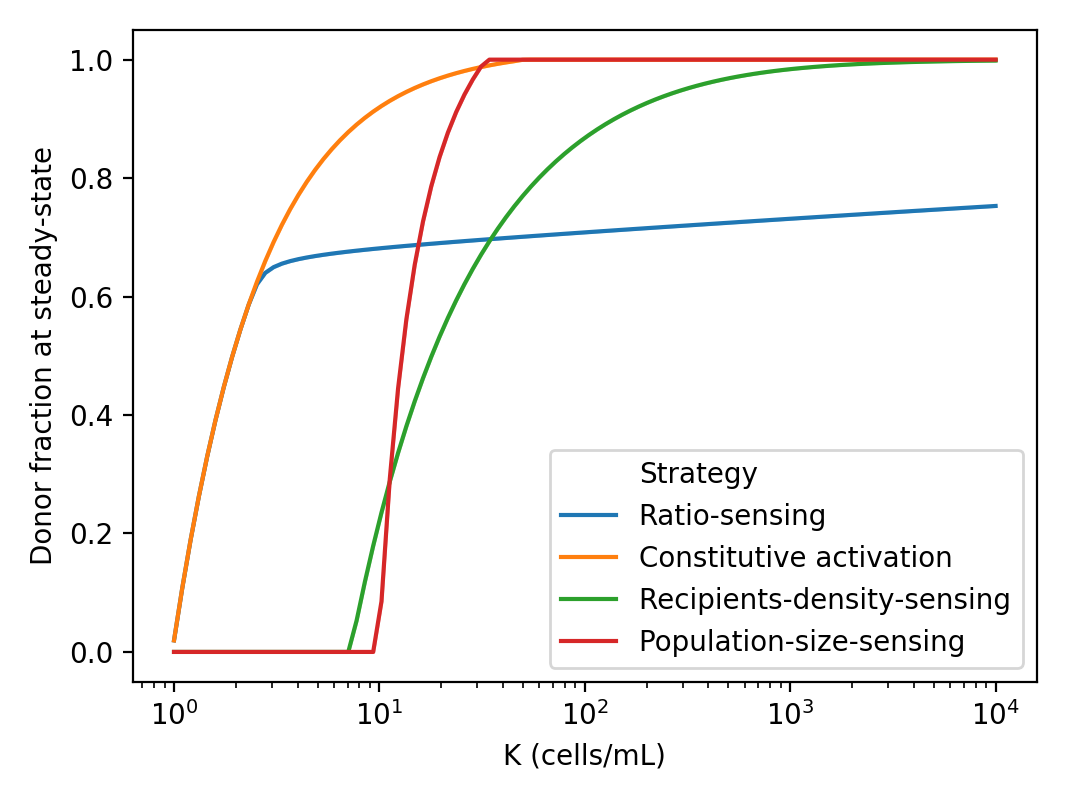

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [6]:
scale = 2/3
dpi = 200
plt.figure(figsize=(scale*8,scale*6), dpi=dpi)
sns.lineplot(data=dfss,x='K', y='fdon', hue='Strategy',ci='sd')
plt.xscale('log')
plt.xlabel('K (cells/mL)')
plt.ylabel('Donor fraction at steady-state')
plt.tight_layout()
plt.savefig('frac.eps')

<IPython.core.display.Javascript object>


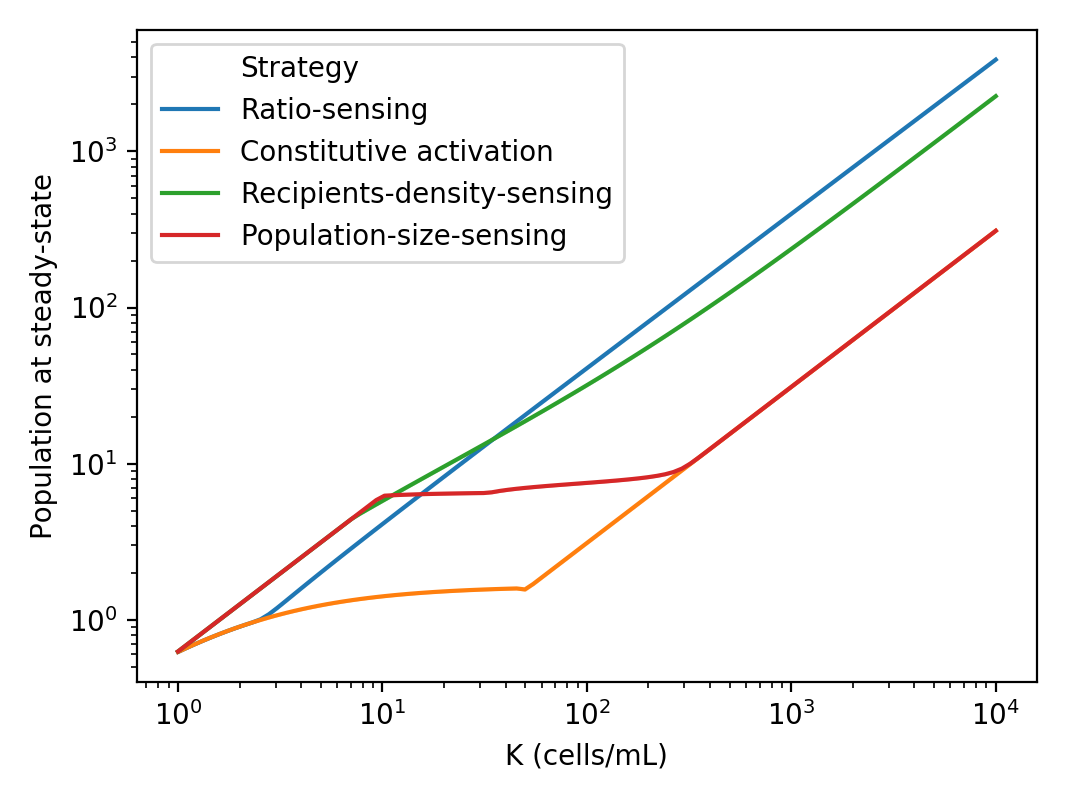

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [7]:
scale = 2/3
dpi = 200
plt.figure(figsize=(scale*8,scale*6), dpi=dpi)
sns.lineplot(data=dfss,x='K', y='p', hue='Strategy')
plt.xscale('log')
plt.xlabel('K (cells/mL)')
plt.yscale('log')
plt.ylabel('Population at steady-state')
plt.tight_layout()
plt.savefig('population.eps')

<IPython.core.display.Javascript object>


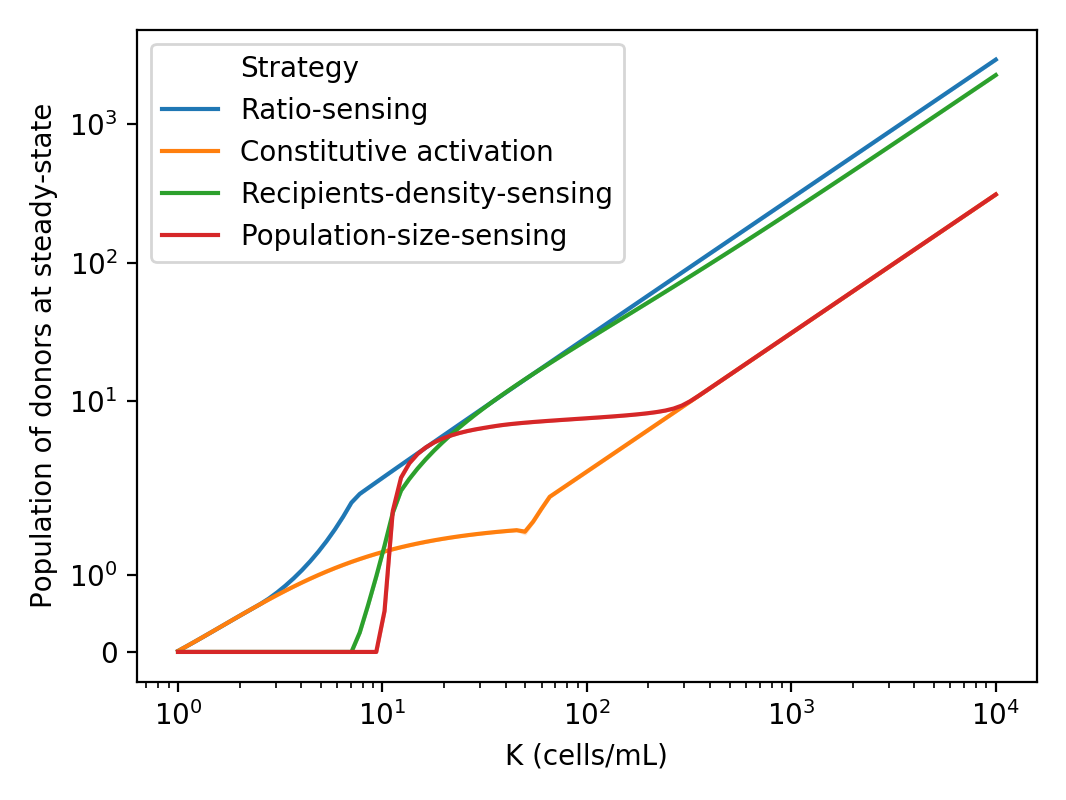

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [8]:
scale = 2/3
dpi = 200
plt.figure(figsize=(scale*8,scale*6), dpi=dpi)
sns.lineplot(data=dfss,x='K', y='d', hue='Strategy',ci='sd')
plt.xscale('log')
plt.xlabel('K (cells/mL)')
plt.yscale('symlog')
plt.ylabel('Population of donors at steady-state')
plt.tight_layout()
plt.savefig('donors.eps')

In [9]:
F, LP, LK = np.mgrid[0.1:0.9:10j, -4:1:10j, 0:4:10j]
P = 10**LP
K = 10**LK
T = 14*24*60

def f_ss(frac,pop,kind, **kwds):
        p_aux = p.copy()
        for (k,v) in kwds.items():
            p_aux[k] = v
        res = integrate(
                y0 = pop*np.array([1-frac, frac],dtype=np.float),
                kind = kind,
                samples = np.linspace(0,T,2000),
                parameters = parameters_series(p_aux).to_numpy(),
                atol=np.array([1e-9,1e-30]),
                rtol=1e-7
            )
        return {'d': res.ys['d'][-1], 'fd': 1-res.ys['f'][-1]}

f_ss_v = np.vectorize(f_ss)

In [10]:
kpv_list = [(0,'theta',p['theta'])] + [(0,'theta',f/(1-f)) for f in np.linspace(0.1,0.9,5)] + [(1,'a',a) for a in np.linspace(0,1,5)] + [(2,'r50',r50) for r50 in 10**np.linspace(-2,2,5)] + [(3,'p50',p50) for p50 in 10**np.linspace(-2,2,5)]
dfrob = pd.DataFrame([{**f_ss(0.5,5e-3,kind,k=k, **{param:val}),'kind':kind, 'k': k, param: val} for k in 10**np.linspace(0,4,30) for (kind,param,val) in kpv_list])

In [11]:
kindspar = {0: 'theta', 1: 'a', 2: 'r50', 3: 'p50'}

dfrob['hue'] = dfrob[['kind','theta','a','r50', 'p50']].apply(
    lambda s: f"{kinds[s['kind']]} ({kindspar[s['kind']]} = {s[kindspar[s['kind']]]:.2})",
    axis=1)

dfrob['maxdatk'] = dfrob.groupby('k')['d'].transform('max')
dfrob['ratio'] = dfrob['d']/dfrob['maxdatk']
dfrob['lk'] = np.log10(dfrob.k)

In [12]:
dfrob.to_csv('dfrob.csv',index=False)

<IPython.core.display.Javascript object>


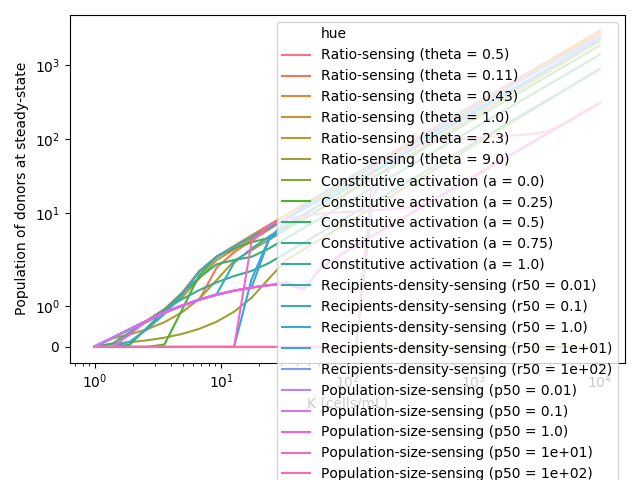

In [13]:
plt.figure()
sns.lineplot(data=dfrob,x='k', y='d', hue='hue',ci='sd')
plt.xscale('log')
plt.xlabel('K (cells/mL)')
plt.yscale('symlog')
plt.ylabel('Population of donors at steady-state')
plt.tight_layout()

<IPython.core.display.Javascript object>


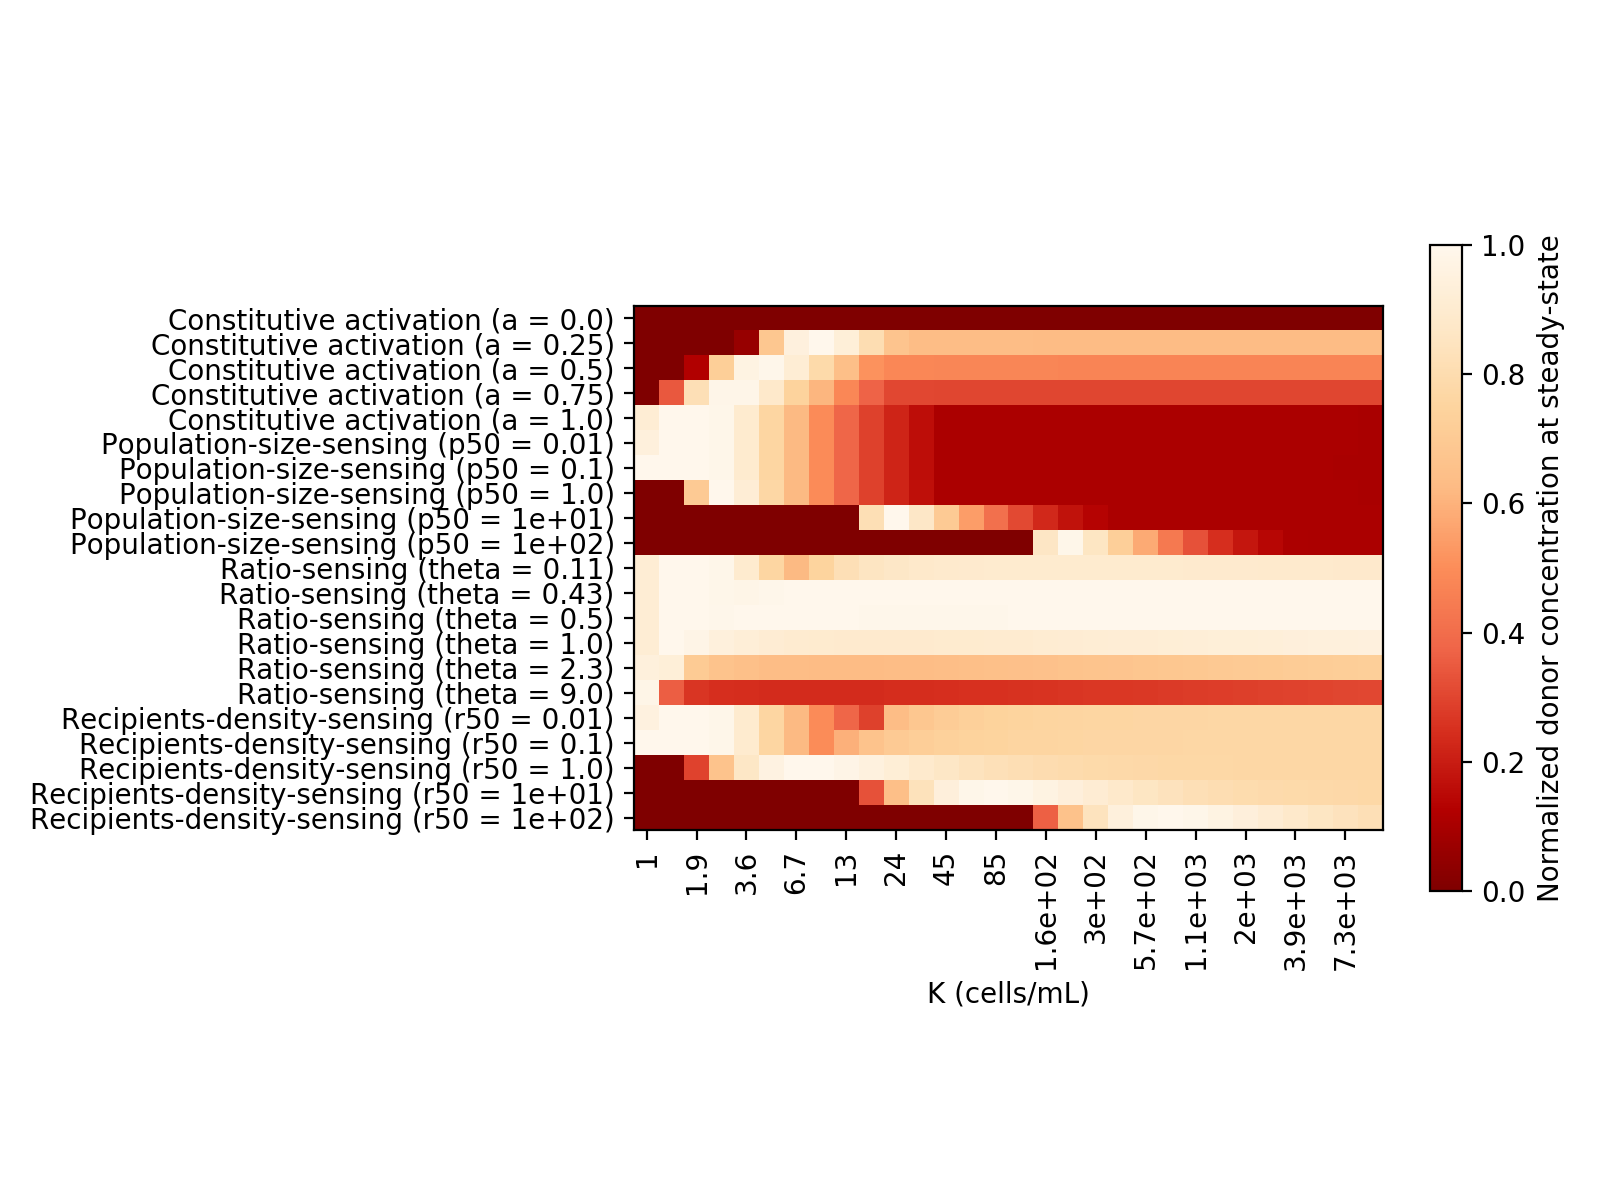

In [14]:
scale = 1
dpi = 200
plt.figure(figsize=(scale*8,scale*6), dpi=dpi)
dfrob['kstr'] = dfrob.k.apply('{:.2g}'.format)
dfpiv = dfrob[['ratio','k','hue']].pivot(index='hue',columns='k',values='ratio')
plt.imshow(dfpiv,cmap='OrRd_r')
plt.xticks(range(0,dfpiv.shape[1],2),['{:.2g}'.format(x) for x in dfpiv.columns[::2]],rotation=90)
plt.ylabel('')
plt.xlabel('K (cells/mL)')
plt.yticks(range(0,dfpiv.shape[0]),dfpiv.index)
c = plt.colorbar(shrink=0.6)
c.set_label('Normalized donor concentration at steady-state')
plt.tight_layout()
None

<IPython.core.display.Javascript object>


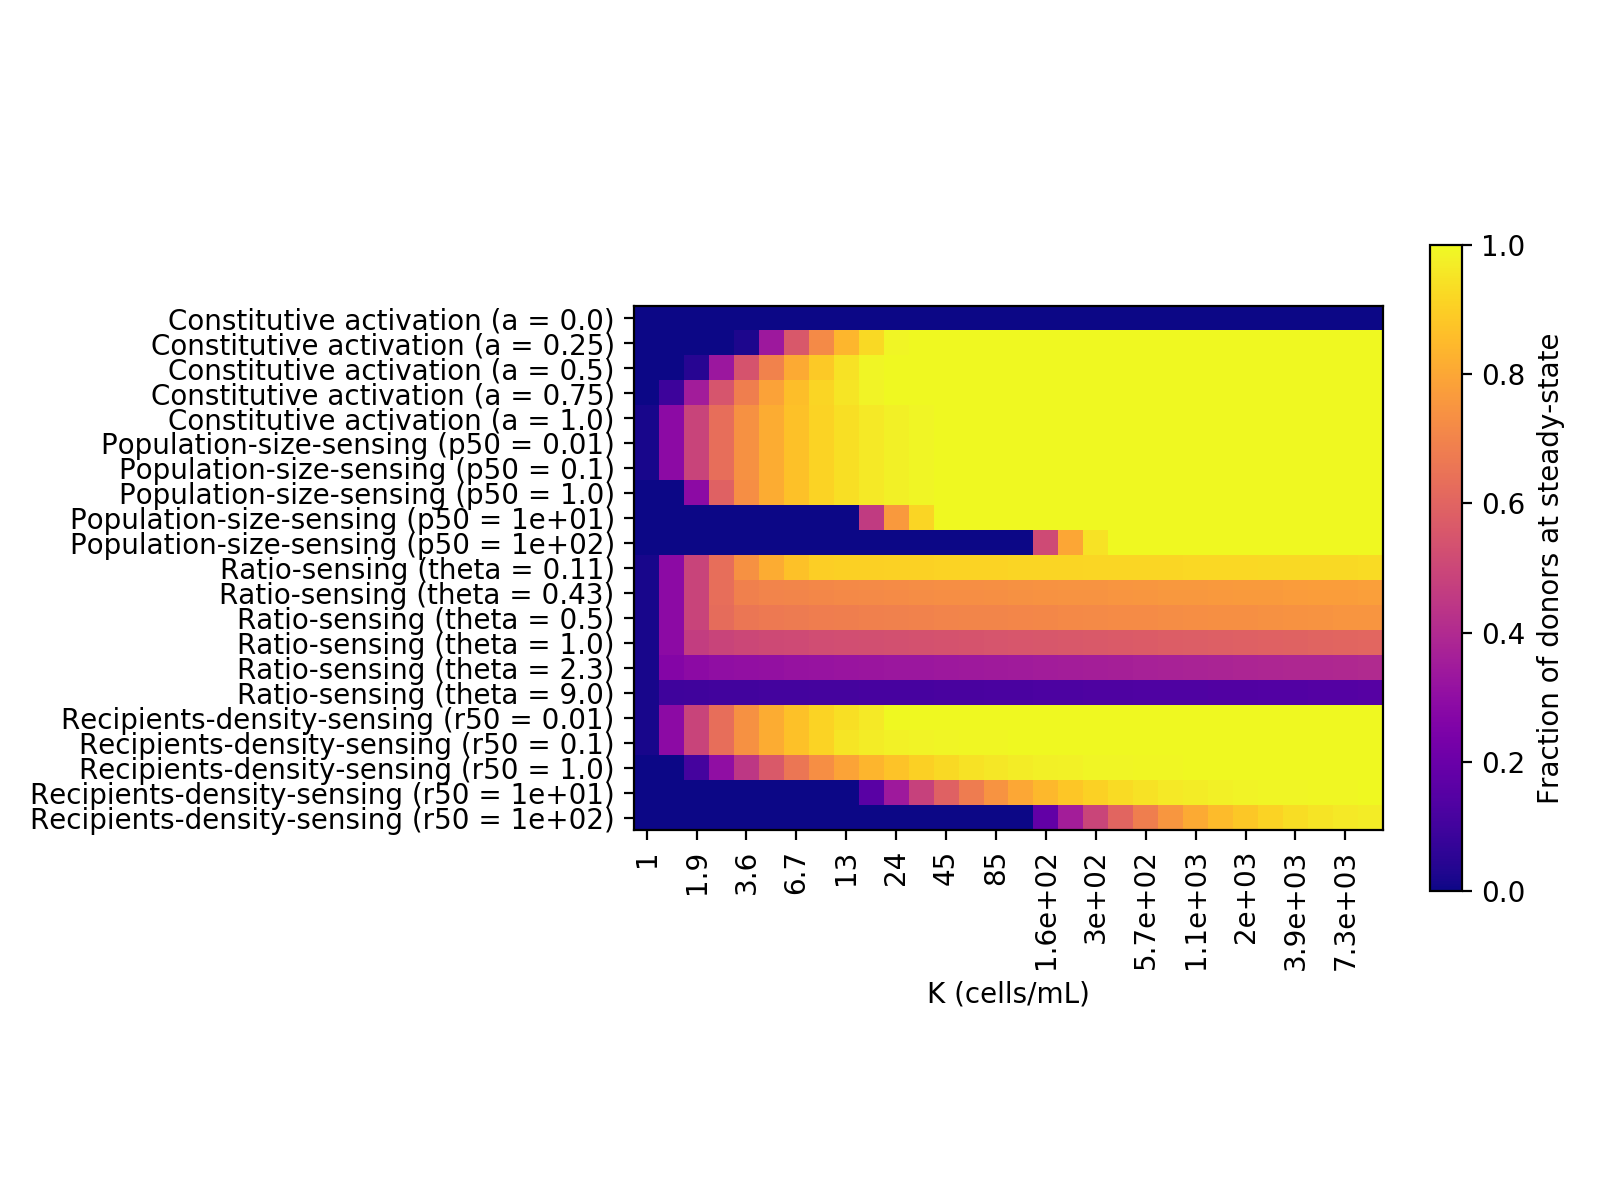

In [15]:
scale = 1
dpi = 200
plt.figure(figsize=(scale*8,scale*6), dpi=dpi)
dfrob['kstr'] = dfrob.k.apply('{:.2g}'.format)
dfpiv = dfrob[['fd','k','hue']].pivot(index='hue',columns='k',values='fd')
plt.imshow(dfpiv,cmap='plasma')
plt.xticks(range(0,dfpiv.shape[1],2),['{:.2g}'.format(x) for x in dfpiv.columns[::2]],rotation=90)
plt.ylabel('')
plt.xlabel('K (cells/mL)')
plt.yticks(range(0,dfpiv.shape[0]),dfpiv.index)
c = plt.colorbar(shrink=0.6)
c.set_label('Fraction of donors at steady-state')
plt.tight_layout()
None